In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import pandas as pd
import torch

from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml
import timeit

!pip install libsvmdata

from libsvmdata import fetch_libsvm

torch_tensor3d = torch.tensor([ 
                             [ 
                             [ 1, 2, 3], 
                             [ 4, 5, 6], 
                             ], 
                             [ 
                             [ 7, 8, 9], 
                             [10, 11, 12], 
                             ], 
                             [ 
                             [13, 14, 15], 
                             [16, 17, 18], 
                             ], 
                             [
                             [19, 20, 21],
                             [22, 23, 24],
                             ] 
                            ])

def moveTo(obj, device): 
    """ 
    obj: the python object to move to a device, or to move its
    ➥ contents to a device
    device: the compute device to move objects to 
    """
    if isinstance(obj, list): 
        return [moveTo(x, device) for x in obj] 
    elif isinstance(obj, tuple): 
        return tuple(moveTo(list(obj), device)) 
    elif isinstance(obj, set): 
        return set(moveTo(list(obj), device)) 
    elif isinstance(obj, dict): 
        to_ret = dict() 
        for key, value in obj.items(): 
            to_ret[moveTo(key, device)] = moveTo(value, device) 
        return to_ret 
    elif hasattr(obj, "to"): 
        return obj.to(device) 
    else: 
        return obj

class SimpleDataset(Dataset):

    def __init__(self, X, y): 
        super(SimpleDataset, self).__init__()
        self.X = X 
        self.y = y

    def __getitem__(self, index): 
        inputs = torch.tensor(self.X.iloc[index, :], dtype=torch.float32)
        targets = torch.tensor(int(self.y[index]), dtype=torch.int64) 
        return inputs, targets

    def __len__(self): 
        return self.X.shape[0]         

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Write a series of for loops that compute the average value in torch_tensor3d.
d1 = 4
d2 = 2
d3 = 3
sum = 0
for i in range(d1):
  for j in range(d2):
    for k in range(d3):
      sum = sum + torch_tensor3d[i,j,k]
print(sum / (d1 * d2 * d3))

NameError: name 'torch_tensor3d' is not defined

In [3]:
# Write code that indexes into torch_tensor3d and prints out the value 13. 
print(torch_tensor3d[2, 0, 0])

tensor(13)


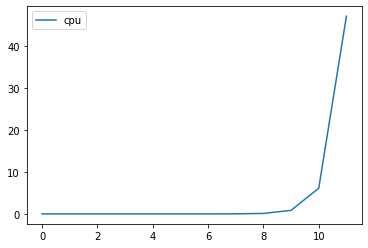

In [5]:
# For every power of 2 (i.e., 2i or 2**i ) up to 211, create a random matrix X ∈ ℝ2i, 2i (i.e., X.shape should give (2**i, 2**i)).
# Time how long it takes to compute XX (i.e., X @ X) on a CPU and on a GPU, and plot the speedup.
# For what matrix sizes is the CPU faster than the GPU? 

result_cpu = np.empty((12, 2))
for i in range(12):
  X = np.random.random((2**i,2**i)) 
  time_cpu = timeit.timeit("X@X", globals=globals(), number=100)
  result_cpu[i, 0] = i
  result_cpu[i, 1] = time_cpu

if torch.cuda.is_available():
  print("GPU acceleration is available")
  device = torch.device("cuda") 
  result_gpu = np.empty((12, 2))
  for i in range(12):
    X = np.random.random((2**i,2**i)) 
    X = moveTo(X, device) 
    time_gpu = timeit.timeit("X@X", globals=globals(), number=100)
    result_gpu[i, 0] = i
    result_gpu[i, 1] = time_gpu
    if result_cpu[i, 1] > result_gpu[i, 1]:
      print(f"2^{i}: GPU wins")
    else:
      print(f"2^{i}: CPU wins")   
  sns.lineplot(x=result_gpu[:,0], y=result_gpu[:,1], label='gpu')  

sns.lineplot(x=result_cpu[:,0], y=result_cpu[:,1], label='cpu')

In [6]:
# We used PyTorch to find the numeric solution to f(x) = (x−2)2.
# Write code that finds the solution to f(x) = sin(x − 2) · (x + 2)2 + √|cos(x)|.
# What answer doyou get? 

def f(x):
  return torch.multiply(torch.sin((x-2.0)), torch.pow(x + 2.0, 2)) + torch.sqrt(torch.abs(torch.cos(x)))

x_param = torch.nn.Parameter(torch.tensor([-3.0]), requires_grad=True)
optimizer = torch.optim.SGD([x_param], lr=0.1)

for epoch in range(100): 
    optimizer.zero_grad()
    loss_incurred = f(x_param) 
    loss_incurred.backward() 
    optimizer.step()
print("x:", x_param.data, "f(x):", f(x_param.data))

x: tensor([1.0635]) f(x): tensor([-6.8625])


In [7]:
# Write a new function that takes two inputs, x and y, where f(x, y) = exp (sin(x)2)/(x−y)2 + (x−y)2 
# Use an Optimizer with initial parameter values of x = 0.2 and y = 10.
# What do they converge to? 

def f(x, y):
  return torch.divide(torch.exp(torch.pow(torch.sin(x), 2.0)),\
                      torch.pow((x - y), 2.0)) +\
                      torch.pow((x - y), 2.0)
x_param = torch.nn.Parameter(torch.tensor([0.2]), requires_grad=True)                      
y_param = torch.nn.Parameter(torch.tensor([10.0]), requires_grad=True)    

optimizer = torch.optim.SGD([x_param, y_param], lr=0.1)

for epoch in range(100): 
    optimizer.zero_grad()
    loss_incurred = f(x_param, y_param) 
    loss_incurred.backward() 
    optimizer.step()
print("x:", x_param.data, "y:", y_param.data,"f(x, y):", f(x_param.data, y_param.data))

x: tensor([3.1419]) y: tensor([4.1419]) f(x, y): tensor([2.])


In [10]:
# Create a function libsvm2Dataset that takes a path to a libsvm dataset file 
# (see https://www.csie.ntu.edu.tw/ cjlin/libsvmtools/datasets/ for many that you can download)
# and create a new dataset object.
# Check that it is the correct length and that each row has the expected number of features. 

def libsvm2Dataset(datasetName):
  X, y = fetch_libsvm(datasetName)
  return SimpleDataset(X, y)

dataset = libsvm2Dataset('bibtex')
print (dataset.X.shape)
print (dataset.y.shape)

(7395, 1836)
(7395, 159)


In [11]:
# Challenging: Use NumPy’s memmap functionality to write the MNIST dataset to disk.
# Then create a MemmapedSimpleDataset that takes the mem-mapped file as input,
# reading the matrix from disk to create PyTorch tensors in the __getitem__ method. Why do you think this would be useful? 

# Load minst data first
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Save data and shape into new file
targetFile = np.memmap('array.npy', dtype='float32', mode='w+', shape=(X.shape[0] + 1, X.shape[1] + 1))
targetFile[0, :2] = X.shape
targetFile[1:, :-1] = X[:]
targetFile[1:, -1] = y[:]


# Solution itself
class MemmapedSimpleDataset(Dataset):

    def __init__(self, fileName): 
      super(MemmapedSimpleDataset, self).__init__()
      self.fileName = fileName

    def __getitem__(self, index): 
      openFile = np.memmap(self.fileName, dtype='float32', mode='r')
      xshape = np.int_(openFile[:2])
      openFile._mmap.close()
      xshape[1]+=1
      sourceFile = np.memmap(self.fileName, dtype='float32', mode='r', shape=tuple(xshape))
      inputs = torch.tensor(sourceFile[index + 1, :-1], dtype=torch.float32)
      targets = torch.tensor(int(sourceFile[index + 1, -1]), dtype=torch.int64) 
      return inputs, targets

    def __len__(self): 
      openFile = np.memmap(self.fileName, dtype='float32', mode='r')
      xshape = np.int_(openFile[:2])
      openFile._mmap.close()
      return xshape[0] 

mmds = MemmapedSimpleDataset('array.npy')
print(len(mmds))
example, label = mmds[0]
print("Features: ", example.shape)
print("Label of index 0: ", label) 

70000
Features:  torch.Size([784])
Label of index 0:  tensor(5)
